In [1]:
import csv                               # csv reader
import pandas as pd
import re                                       # regular expressions
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier

# To do preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score # to report on precision and recall
import numpy as np # To compute the average results

from random import shuffle # To shuffle the dataset

from imblearn.under_sampling import RandomUnderSampler

# To use feature selection in the Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_of_file = '/content/drive/MyDrive/Colab Notebooks/Logically.ai/complaints.csv'

In [4]:
columns = ["Complaint ID", "Company", "Issue", "Consumer complaint narrative", "Sub-product", "Product"]
df = pd.read_csv(path_of_file, usecols= columns)

In [5]:
df.head()

,Product,Sub-product,Issue,Consumer complaint narrative,Company,Complaint ID
0,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,NaN,CAPITAL ONE FINANCIAL CORPORATION,3274605
1,Vehicle loan or lease,Loan,Struggling to pay your loan,I contacted Ally on Friday XX/XX/XXXX after fa...,ALLY FINANCIAL INC.,3425257
2,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",3198225
3,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,I have 2 Capital One credit cards and My wife ...,CAPITAL ONE FINANCIAL CORPORATION,3202016
4,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,NaN,"EQUIFAX, INC.",3206138


# check for null values

In [6]:
df.isnull().values.any()

True

In [7]:
nan_values = df.isna()
nan_columns = nan_values.any()
columns_with_nan = df.columns[nan_columns].tolist()
print(columns_with_nan)

['Sub-product', 'Consumer complaint narrative']


## since its a string data so fill with empty space

In [8]:
df.fillna('', inplace=True)
df.isnull().values.any()

False

# check class imbalance

In [9]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    837147
Debt collection                                                                 382216
Mortgage                                                                        337857
Credit reporting                                                                140432
Credit card or prepaid card                                                     122003
Checking or savings account                                                     101178
Credit card                                                                      89190
Bank account or service                                                          86206
Student loan                                                                     63174
Money transfer, virtual currency, or money service                               32982
Consumer Loan                                                                    31602
Vehicle loan or lease                      

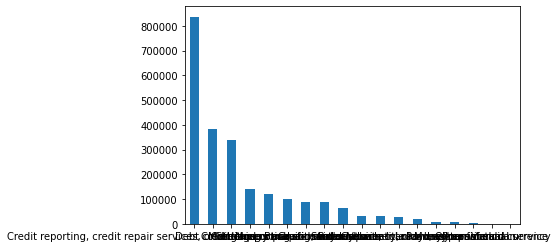

In [10]:
count_classes = df['Product'].value_counts()
count_classes.plot(kind = 'bar', rot = 0)

## encode the Y label

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Product'] = le.fit_transform(df['Product'])
# print(le.inverse_transform(1))

In [12]:
df.head()

,Product,Sub-product,Issue,Consumer complaint narrative,Company,Complaint ID
0,6,Credit reporting,Incorrect information on your report,,CAPITAL ONE FINANCIAL CORPORATION,3274605
1,16,Loan,Struggling to pay your loan,I contacted Ally on Friday XX/XX/XXXX after fa...,ALLY FINANCIAL INC.,3425257
2,6,Credit reporting,Incorrect information on your report,,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",3198225
3,4,General-purpose credit card or charge card,Fees or interest,I have 2 Capital One credit cards and My wife ...,CAPITAL ONE FINANCIAL CORPORATION,3202016
4,6,Credit reporting,Incorrect information on your report,,"EQUIFAX, INC.",3206138


## seperating the X attributes and the Y label for under sampling

In [13]:
columns = df.columns.tolist()
# df.drop('Complaint ID')
data_columns = [c for c in columns if c not in ["Product"]]
X = df[data_columns]
Y = df['Product']
Y = Y.to_frame()

In [14]:
print(type(X), type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [15]:
X.drop("Complaint ID", axis=1, inplace=True)
X

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Sub-product,Issue,Consumer complaint narrative,Company
0,Credit reporting,Incorrect information on your report,,CAPITAL ONE FINANCIAL CORPORATION
1,Loan,Struggling to pay your loan,I contacted Ally on Friday XX/XX/XXXX after fa...,ALLY FINANCIAL INC.
2,Credit reporting,Incorrect information on your report,,"TRANSUNION INTERMEDIATE HOLDINGS, INC."
3,General-purpose credit card or charge card,Fees or interest,I have 2 Capital One credit cards and My wife ...,CAPITAL ONE FINANCIAL CORPORATION
4,Credit reporting,Incorrect information on your report,,"EQUIFAX, INC."
...,...,...,...,...
2286323,I do not know,Cont'd attempts collect debt not owed,I have disputed my debts several times with no...,Bonneville Billing and Collections
2286324,Conventional fixed mortgage,"Loan modification,collection,foreclosure",My father died in XX/XX/XXXX. Left me his only...,"CITIBANK, N.A."
2286325,,Credit reporting company's investigation,cfbp i would Like to file a complaint on Exper...,Experian Information Solutions Inc.
2286326,,Incorrect information on credit report,My husband and I are in the middle of an FHA S...,"TRANSUNION INTERMEDIATE HOLDINGS, INC."


# Under sampling the Data

In [16]:
rus = RandomUnderSampler(sampling_strategy= 'majority', random_state= 42)
X_res, y_res = rus.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [17]:
print(y_res.shape, X_res.shape)

(1449199, 1) (1449199, 4)


In [18]:
combined_arr = np.column_stack((np.array(X_res), np.array(y_res)))

## creating a new dataframe after undersampling the Data

In [19]:
resampled_df = pd.DataFrame(combined_arr, columns= ["Sub product", "Issue", "Consumer complaint narative", "Company", "Product"]) 
resampled_df

,Sub product,Issue,Consumer complaint narative,Company,Product
0,Other bank product/service,"Account opening, closing, or management",,UBS BANK USA,0
1,Checking account,Problems caused by my funds being low,,"CITIZENS FINANCIAL GROUP, INC.",0
2,Other bank product/service,"Account opening, closing, or management",My name is XXXX XXXX XXXX and huband name is X...,"CITIBANK, N.A.",0
3,Other bank product/service,"Making/receiving payments, sending money",XXXX 2015 : I called to make a payment on XXXX...,U.S. BANCORP,0
4,Checking account,Deposits and withdrawals,,JPMORGAN CHASE & CO.,0
...,...,...,...,...,...
1449194,Domestic (US) money transfer,Fraud or scam,Signedup XXXX family members for referrals on ...,"Coinbase, Inc.",17
1449195,Domestic (US) money transfer,Other service issues,I received a random notice 3 days ago from a d...,Circle Internet Financial,17
1449196,Domestic (US) money transfer,Fraud or scam,Signed up with Coinbase.com with a {$75.00} si...,"Coinbase, Inc.",17
1449197,Domestic (US) money transfer,Other transaction issues,Money was going to be transferred from XXXX to...,"Coinbase, Inc.",17


## method for Loading the data and splitting the data

In [21]:
def loadData(dataframe):
  for index, row in dataframe.iterrows():
    (company, issue, complaint_narative, sub_product, product) = parseReviewImproved(row)
    rawData.append((company, issue, complaint_narative, sub_product, product))


def parseReviewImproved(reviewLine):
    company = reviewLine['Company']
    issue = reviewLine['Issue']
    # sub_issue = reviewLine['Sub-issue']
    complaint_narative = reviewLine['Consumer complaint narative']
    sub_product = reviewLine['Sub product']
    product = reviewLine['Product']
    return (company, issue, complaint_narative, sub_product, product)

def splitData(percentage):
    dataSamples = len(rawData)
    halfOfData = int(len(rawData)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    for (company, issue, complaint_narative, sub_product, product) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(company, sub_product, preProcess(issue), preProcess(complaint_narative)),product))
    for (company, issue, complaint_narative, sub_product, product) in rawData[trainingSamples:halfOfData] + rawData[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(company, sub_product, preProcess(issue), preProcess(complaint_narative)),product))

## converting tokens to feature vectore

In [22]:
# featureDict = {} # the global feature dictionary

def toFeatureVector(company, sub_product, issue_tokens, complaint_tokens):

    # return a dictionary 'featureVect' where the keys are the tokens in 'words' and the values are the number of occurrences of the tokens
    # start by using binary values only:
    # baseDict = {}
    featureVec = {}

    for w in issue_tokens:
      try:
          featureVec[w] += 1.0/len(issue_tokens)
      except KeyError:
          featureVec[w] = 1.0/len(issue_tokens)
      # try:
      #     featureDict[w] += 1.0/len(issue_tokens)
      # except KeyError:
      #     featureDict[w] = 1.0/len(issue_tokens)

        
    for w in complaint_tokens:
      try:
          featureVec[w] += 1.0/len(complaint_tokens)
      except KeyError:
          featureVec[w] = 1.0/len(complaint_tokens)
      # try:
      #     featureDict[w] += 1.0/len(complaint_tokens)
      # except KeyError:
      #     featureDict[w] = 1.0/len(complaint_tokens)

    
    featureVec['COMPANY:'+str(company).lower()] = 1.0 # 0.5
    featureVec['SUB:'+str(sub_product).lower()] = 1.0 #0.3

    # try:
    #     featureDict['COMPANY:'+str(company)] += 1.0
    # except KeyError:
    #     featureDict['COMPANY:'+str(company)] = 1.0

    # try:
    #     featureDict['SUB:'+str(sub_product)] += 1.0
    # except KeyError:
    #     featureDict['SUB:'+str(sub_product)] = 1.0

    
    return featureVec

## Preprocessing the Data and the complaints and making it simple

In [23]:
def preProcess(text):
    # should return a list of tokens
    
    # word tokenisation, including punctuation removal
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # lowercasing
    tokens = [t.lower() for t in tokens]

    # stopword removal- benefits are it removes rare words, though bad for bigram relations
    if True:
        stop = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop]
    
    # lemmatisation
    if True:
        lemmatiser = WordNetLemmatizer()
        tokens = [lemmatiser.lemmatize(t) for t in tokens]
        
    # stemming- works well with stop word remove
    if False:
        p_stemmer = PorterStemmer()
        tok = []
        for t in tokens:
            tok.append(p_stemmer.stem(t))
        tokens = tok
        
    tokens = [t for t in tokens if t] # ensure no empty space
    
    return tokens


In [24]:
print(preProcess("Dear Consumer Financial Protection Bureau Someone had fraudulently created a credit card account with XXXX XXXX and charged over {$5200.00} under my name and this amount has been over due for several months now. I do not bank with XXXX XXXX. "))

['dear', 'consumer', 'financial', 'protection', 'bureau', 'someone', 'fraudulently', 'created', 'credit', 'card', 'account', 'xxxx', 'xxxx', 'charged', '5200', '00', 'name', 'amount', 'due', 'several', 'month', 'bank', 'xxxx', 'xxxx']


In [25]:
# loading reviews
rawData = [] 
trainData = [] 
testData = [] 
# do the actual stuff
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)))
print("Preparing the dataset...")
loadData(resampled_df)
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)))
print("Preparing training and test data...")
splitData(0.8)
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)))



Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 1449199 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 1449199 rawData, 1159358 trainData, 289841 testData


# defining out training classifier which is linearSVC with Tfidf Transformer

In [26]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC(loss = 'hinge'))])
    return SklearnClassifier(pipeline).train(trainData)

# method for Predicting the labels

In [27]:
def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

# method for cross validation to 10 folds

In [28]:
def crossValidate(dataset, folds):
    shuffle(dataset) # this shuffles the dataset
    cv_results = [] # an empty list for storing the results
    accuracy = []
    foldSize = int(len(dataset)/folds) # foldsize is the size we get dividing the length of dataset by number of folds
    
    precision = recall = fscore = 0 # variables to store the average result
    
    for i in range(0,len(dataset),foldSize):
        # spitting the dataset in training and validation set
        trainingData = dataset[0:i] + dataset[i+foldSize:]
        validationData = dataset[i:i+foldSize]
        # training the classifier on the split training data
        classifier = trainClassifier(trainingData)
        # this variable stores the label for final scores
        testTrue = [label[1] for label in validationData]
        # predicting labels on the validation data
        testPred = predictLabels(validationData, classifier)
        # finalscores stores the value for precision recall fscore and accuracy
        finalScores = precision_recall_fscore_support(testTrue, testPred, average = 'weighted')
        accuracy.append(accuracy_score(testTrue, testPred))
        cv_results.append(finalScores)
        
    print('Cross validation done on the dataset and metrics scores are')
    
    #this for loop block takes the mean of precision, recall, fscore for 10 folds of training and validation data
    for scores in cv_results:
        precision += scores[0]
        recall += scores[1]
        fscore += scores[2]
        
    cv_results = (precision/len(cv_results), recall/len(cv_results), fscore/len(cv_results))
    accuracy_result = sum(accuracy)/ len(accuracy) 
    return cv_results, accuracy_result

In [29]:
cv_results, accuracy = crossValidate(trainData, 10)
print("Precision: %f\nRecall: %f\nF Score:%f" % cv_results[:3])
print("accuracy on cross validation is: ", accuracy)

Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Classifier...
Cross validation done on the dataset and metrics scores are
Precision: 0.993942
Recall: 0.993741
F Score:0.993724
accuracy on cross validation is:  0.9937410069121804


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## accuracy on the Test Data

In [30]:
print(testData[0])   # have a look at the first test data instance
classifier = trainClassifier(trainData)  # train the classifier
testTrue = [t[1] for t in testData]   # get the ground-truth labels from the data
testPred = predictLabels(testData, classifier)  # classify the test data to get predicted labels
finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluate
accuracy = accuracy_score(testTrue, testPred)
print("Done training!")
print("Precision: %f\nRecall: %f\nF Score:%f" % finalScores[:3])
print("accuracy om Test Data is: ", accuracy)

({'written': 0.3333333333333333, 'notification': 0.3333333333333333, 'debt': 0.3333333333333333, 'spoke': 0.027777777777777776, 'representative': 0.05555555555555555, 'regarding': 0.027777777777777776, 'degratory': 0.027777777777777776, 'information': 0.05555555555555555, 'credit': 0.05555555555555555, 'report': 0.05555555555555555, 'inquired': 0.027777777777777776, 'one': 0.027777777777777776, 'account': 0.08333333333333333, 'notified': 0.05555555555555555, 'second': 0.027777777777777776, 'properly': 0.027777777777777776, 'able': 0.027777777777777776, 'resolve': 0.027777777777777776, 'delinquent': 0.027777777777777776, 'asked': 0.027777777777777776, 'could': 0.05555555555555555, 'pay': 0.027777777777777776, 'balance': 0.027777777777777776, 'deleted': 0.027777777777777776, 'told': 0.027777777777777776, 'law': 0.027777777777777776, 'thing': 0.027777777777777776, 'company': 0.027777777777777776, 'show': 0.027777777777777776, 'paid': 0.027777777777777776, 'derogatory': 0.02777777777777777

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done training!
Precision: 0.434502
Recall: 0.585424
F Score:0.492852
accuracy om Test Data is:  0.5854244223557054


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


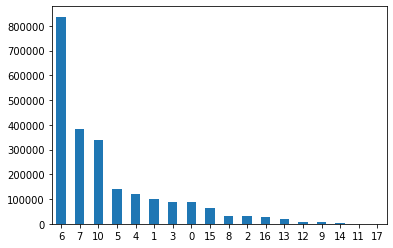

In [ ]:
columns = df.columns.tolist()
# df.drop('Complaint ID')
data_columns = [c for c in columns if c not in ["Product"]]
X = df[data_columns]
Y = df['Product']
Y = Y.to_frame()

In [ ]:
print(type(X), type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [ ]:
X.drop("Complaint ID", axis=1, inplace=True)
X


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Sub-product,Issue,Consumer complaint narrative,Company
0,Credit reporting,Incorrect information on your report,,CAPITAL ONE FINANCIAL CORPORATION
1,Loan,Struggling to pay your loan,I contacted Ally on Friday XX/XX/XXXX after fa...,ALLY FINANCIAL INC.
2,Credit reporting,Incorrect information on your report,,"TRANSUNION INTERMEDIATE HOLDINGS, INC."
3,General-purpose credit card or charge card,Fees or interest,I have 2 Capital One credit cards and My wife ...,CAPITAL ONE FINANCIAL CORPORATION
4,Credit reporting,Incorrect information on your report,,"EQUIFAX, INC."
...,...,...,...,...
2286323,I do not know,Cont'd attempts collect debt not owed,I have disputed my debts several times with no...,Bonneville Billing and Collections
2286324,Conventional fixed mortgage,"Loan modification,collection,foreclosure",My father died in XX/XX/XXXX. Left me his only...,"CITIBANK, N.A."
2286325,,Credit reporting company's investigation,cfbp i would Like to file a complaint on Exper...,Experian Information Solutions Inc.
2286326,,Incorrect information on credit report,My husband and I are in the middle of an FHA S...,"TRANSUNION INTERMEDIATE HOLDINGS, INC."


In [ ]:
print(y_res.shape, X_res.shape)

(1449199, 1) (1449199, 4)


In [ ]:
for index, row in X.iterrows():
    str(row['Sub-product'])
    str(row['Issue'])
    str(row['Sub-issue'])
    str(row['Consumer complaint narrative'])
    str(row['Company'])
    str(row['Complaint ID'])


In [ ]:
# for index, row in X.iterrows():
    # print(type(row['Sub-product']))

In [ ]:
nan_values = X.isna()
nan_columns = nan_values.any()
columns_with_nan = X.columns[nan_columns].tolist()
print(columns_with_nan)
X.fillna('', inplace=True)

[]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
Y.isnull().values.any()

False

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X.values.ravel())
X_trans=vectorizer.transform(X.values.ravel())
X_trans=X_trans.toarray()
X = pd.DataFrame(X_trans)

AttributeError: ignored

In [ ]:
# le = preprocessing.LabelEncoder()
# Y_trans = le.fit_transform(Y)
# Y = pd.DataFrame(Y_trans)

In [ ]:
# Y

In [ ]:
# nm = NearMiss(random_state= 45)
# X_res, Y_res = nm.fit_resample(X,Y)
# define pipeline
over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# transform the dataset
X, Y = over.fit_resample(X, Y)

ValueError: ignored